<a href="https://colab.research.google.com/github/hedgehog-zowie/tf-study/blob/master/imdb_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

第二个tensorflow例子，使用tensorflow的keras api实现imdb的影评分类。

一、导入相关module。

In [1]:
# import modules
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# 查看各个module的版本
print('tensorflow version: ', tf.__version__)
print('numpy version: ', np.__version__)
print('matplot version: ', mpl.__version__)

tensorflow version:  1.13.0-rc1
numpy version:  1.14.6
matplot version:  3.0.2


二、准备imdb数据集。

In [2]:
imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words = 10000)
print('train_data.shape: ', train_data.shape)
print('test_data.shape: ', test_data.shape)
print(train_data[0])
type(train_data)

train_data.shape:  (25000,)
test_data.shape:  (25000,)
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


numpy.ndarray

三、数据预处理，将影评数组处理成具有相同长度(max_length)的数组，以便于创建一个形状为*max_length X num_reviews*的整数张量。

In [3]:
# pad_sequences可以将一个序列处理成2D Numpy 矩阵
# padding='post'表示在后面补齐，与之对应的还有padding='pre'，表示在前面补齐
# truncating='post'表示在后面截断，对应的有truncating='pre'，表示在前面截断
# maxlen为最大长度，可省略，若省略则为train_data中最长的序列长度
# value为要补的值
train_data = keras.preprocessing.sequence.pad_sequences(train_data, value = 0, padding = 'post', maxlen = 256)
test_data = keras.preprocessing.sequence.pad_sequences(test_data, value = 0, padding = 'post', maxlen = 256)
print('train_data.shape: ', train_data.shape)
print('test_data.shape: ', test_data.shape)
print(train_data[0])
type(train_data)

train_data.shape:  (25000, 256)
test_data.shape:  (25000, 256)
[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    

numpy.ndarray

四、构建模型

In [4]:
model = keras.Sequential()
# 由于单词组成的矩阵非常稀疏（一个向量仅1个1，其余全为0），因此将10000个单词（准备数据时只取了频率最高的10000个词）组成的单词表转换成16维的词向量来表示，以达到降维的目的（10000维 -> 16维）。
model.add(keras.layers.Embedding(10000, 16))
# 池化层，其作用主要有：
# 1.保留主要特征的同时减少参数（降低维度，类似PCA）和计算量，防止过拟合，提高模型的泛化能力。
# 2.不变性，包括translation(平移)，rotation(旋转)，scale(尺度)，更关注是否存在某些特征而不是特征具体的位置。
# 3.获得定长输出，文本分类的输入是不定长的，可以通过池化获得定长输出，也是本例中使用池化层的目的。
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation = tf.nn.relu))
model.add(keras.layers.Dense(1, activation = tf.nn.sigmoid))
# 打印出模型概述信息
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


五、编译模型

In [0]:
model.compile(optimizer=tf.train.AdamOptimizer(), loss='binary_crossentropy', metrics=['accuracy'])

六、训练模型

Train on 15000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/40
15000/15000 [==============================] - 1s 70us/sample - loss: 0.6923 - acc: 0.5281 - val_loss: 0.6909 - val_acc: 0.5761
Epoch 2/40
15000/15000 [==============================] - 1s 59us/sample - loss: 0.6874 - acc: 0.6577 - val_loss: 0.6837 - val_acc: 0.6984
Epoch 3/40
15000/15000 [==============================] - 1s 58us/sample - loss: 0.6757 - acc: 0.7327 - val_loss: 0.6684 - val_acc: 0.7548
Epoch 4/40
15000/15000 [==============================] - 1s 58us/sample - loss: 0.6537 - acc: 0.7573 - val_loss: 0.6431 - val_acc: 0.7593
Epoch 5/40
15000/15000 [==============================] - 1s 60us/sample - loss: 0.6211 - acc: 0.7901 - val_loss: 0.6091 - val_acc: 0.7845
Epoch 6/40
15000/15000 [==============================] - 1s 60us/sample - loss: 0.5798 - acc: 0.8099 - val_loss: 0.5694 - val_acc: 0.7985
Epoch 7/40
15000/15000 [==============================] - 1s 59us/sa

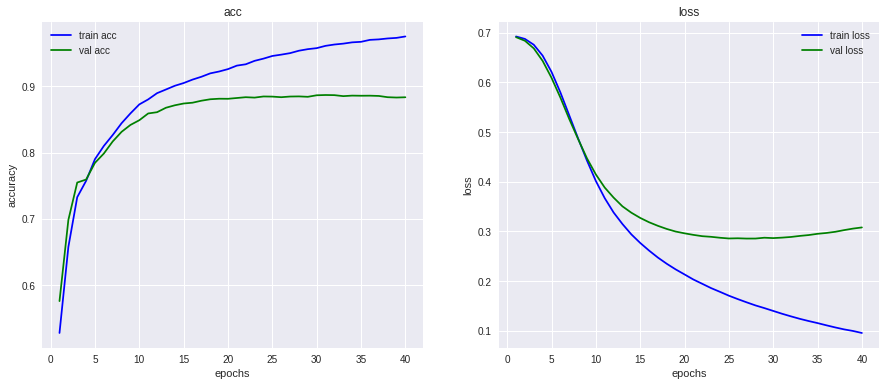

In [6]:
# 准备训练集与验证集
x_val = train_data[:10000]
partial_x_train = train_data[10000:]
y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

# 训练模型
history = model.fit(partial_x_train, partial_y_train, epochs=40, batch_size=512, validation_data=(x_val, y_val), verbose=1)
history_dict = history.history
print('history_dict.keys(): ', history_dict.keys())

# 画图
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.title('acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(epochs, acc, color='blue', label='train acc')
plt.plot(epochs, val_acc, color='green', label='val acc')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(epochs, loss, color='blue', label='train loss')
plt.plot(epochs, val_loss, color='green', label='val loss')
plt.legend()

plt.show()

七、评估模型

In [7]:
results = model.evaluate(test_data, test_labels)
print(results)

25000/25000 [==============================] - 1s 36us/sample - loss: 0.3293 - acc: 0.8718
[0.3292664639663696, 0.8718]
